# Lab Session - Probability Distributions and Basic ML Concepts
---

In this lab session, we are going to consider various probability distributions, conjugacy, Maximum Likelihood and overfitting, as covered in lecture 3 and 4.

__Note__: You can complete the lab entering code only in the  __# EXPECTED SPACE FOR STUDENT CODE__-blocks as well as the empty cells.

In [1]:
# Imports
# Can be installed through "pip install numpy scipy pandas matplotlib ipympl" or "pip install -r requirements.txt"
import time
from functools import partial
import numpy as np
from scipy.stats import norm, beta as beta_dist, gamma as gamma_dist, poisson as poisson_dist, nbinom as nbinom_dist
from scipy.linalg import det, inv, pinv
from scipy.optimize import minimize
import pandas as pd
import math
import matplotlib.pyplot as plt
from utils import plot_gaussian, show_images, show_marginals


# Exercise 1: Gaussian Distributions

We will start by considering the most prevalent distribution - the Gaussian. As stated in Lecture 3 (Section on Gaussians) the Gaussian has several appealing properties that makes it easy to work with. In the following tasks, we will highlight some of these.

**Note:** For the following tasks, the purpose is to understand the properties of Gaussian distributions. As such, any readly-made distributions (scipy.stats.norm etc.) are disallowed. Using NumPy or SciPy for Linear Algebra is permitted.

Below, you see an implementation of a Gaussian distribution. We will use this highlight and implement properties that are typical of the Gaussian distribution. Please read through, and note the dunder (double under, \_\_methodname_\__) methods that are implemented. These allow us to add and subtract one Gaussian with another.

In [2]:
class GaussianDistribution:
    
    def __init__(self, mean, cov):
        """
        A Gaussian Distribution in arbitrary number of dimensions

        Args:
            mean (np.ndarray): Mean of the distribution.
            cov (np.ndarray): Covariance of the distribution.
        """
        self.mean = np.array(mean).reshape(1, -1)
        self.cov = np.array(cov)
        self.dims = self.mean.shape[1]
        
    def __str__(self):
        """
        Generates a string representation of the object, used for plotting
        and printing

        Returns:
            str: String representation of the object
        """        
        if self.dims == 2:
            string = f'Gaussian, Dim: {self.dims}    Mean: {self.mean}    Covariance: {self.cov[0, :]}{self.cov[1, :]}'
            
        else:
            string = f'Gaussian, Dim: {self.dims}    Mean: {np.round(self.mean[0, 0], 6)}    Covariance: {self.cov}'
        return string.replace('][', '     ').replace('[', '  ').replace(']', '  ')
        
    
    def __add__(self, other):
        """
        Adds two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean + other
            cov = self.cov
        
        else:
            mean = self.mean + other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)
              
    def __sub__(self, other):
        """
        Subtracts two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean - other
            cov = self.cov
            
        else:
            mean = self.mean - other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)  
           
    # sampling is a bit intricate - thus, we cheat a little bit here
    def sample(self, n_samples=1):
        """
        Samples from the distribution.

        Args:
            n_samples (int, optional): The number of samples to generate.
            Defaults to 1.

        Returns:
            np.ndarray: A numpy array of the sampled points.
        """        
        return norm(self.mean, self.cov).rvs(n_samples)
            
    # probability density function - general form
    def pdf(self, points):
        '''
        Evaluates the probability density function of the distribution.

        Args:
            points (np.ndarray): the points we want the probability density of,
            can come in either a list, np.array([dims]) or np.array([samples, dims])
            format
        
        Returns: 
            np.ndarray: A numpy array of probability densities
        '''

        points = np.array(points)
        if len(points.shape) == 1:
            points = points.reshape(1, -1)
            
        offset = points - self.mean
        if self.dims == 1:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(self.cov))
            exponent = np.exp(-0.5 * np.power(offset, 2) / self.cov)
            return norm_const * exponent
            
        else:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(det(self.cov)))
            exponent = np.exp(-0.5 * offset.dot((inv(self.cov)).dot(offset.T)))
            return np.diag(exponent * norm_const)
    
    
    def get_conditional(self, dim, value):
        '''
        Computes the conditional distribution on the remaining dimensions given
        the conditioned value in dimension dim.

        Args:
            dim: int - the dimension (assume only one) which we condition on
            value: float - the value of the conditioned dimension
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START


        
        non_cond_dims = np.arange(self.dims) != dim #x
        cond_dims = np.arange(self.dims) == dim #y

        #cross-variance matrix between x and y
        #self.cov[cond_dims, non_cond_dims][:, np.newaxis]
        cov_xy = self.cov[non_cond_dims, cond_dims][:, np.newaxis]
        cov_xx = self.cov[non_cond_dims, non_cond_dims][:, np.newaxis]
        cov_yx = self.cov[cond_dims, non_cond_dims][:, np.newaxis]
        cov_yy = self.cov[cond_dims, cond_dims][:, np.newaxis]
        cov_yy_inv =  np.linalg.inv(cov_yy)

        conditional_mean = self.mean[0, non_cond_dims] + cov_xy @ cov_yy_inv * (value - self.mean[0, cond_dims])
        conditional_cov = cov_xx - cov_xy @ cov_yy_inv @ cov_yx
        
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(conditional_mean, conditional_cov)

    def marginalize(self, dim):
        '''
        Computes the marginal distribution on the remaining dimensions when having
        marginalized out dimension dim.
        
        Args:
            dim: int - the dimension (assume only one) which we marginalize
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        # Remove the mean and covariance corresponding to the marginalized dimension
        marginal_mean = np.delete(self.mean, dim)
        marginal_cov = np.delete(np.delete(self.cov, dim, axis=0), dim, axis=1)
        
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(marginal_mean, marginal_cov)


__Hint 1__: Use the numpy arrays to retrieve the right dimensions when performing the computation (`cond_dims` are the dimensions we condition on - $y$ in the lecture notes, `non_cond_dims` are the non-conditioned dimensions - $x$ in the lectures). Example:

__Hint 2__: Use either np.matmul, np.dot or the @ operator to perform matrix matrix multiplications.

### Exercise 1.1
We first want to demonstrate how a Gaussian looks and how it is expected to behave - particularly its linear properties. __Throughout this task, we assume that the random variables we work with are independent of one another__ (e.g. __A__ is independent of __B__). Create four Gaussians:

__A__: $\mu = 1, \sigma^2 = 2$

__B__: $\mu = -2, \sigma^2 = 0.1$

__C__: $\mu = \begin{bmatrix}
1 & 0
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & 0.9\\
0.9 & 2
\end{bmatrix}$

__D__: $\mu = \begin{bmatrix}
-1 & 2
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & -0.7\\
-0.7 & 1
\end{bmatrix}$

Visualize, through the provided plotting function below, _plot_gaussian_:

a. __A__

b. __B__

c. __A__ + __B__

d. __C__

e. __D__

f. __C__ - __D__

__Questions__:

1. What is meant by "The Gaussian distribution is fully characterized by its mean and covariance"?
2. If two Gaussians are added, can the (co-)variance ever decrease?

__Answers__:

1. The gaussian distribution is symmetric arounds its mean, i.e. the probability is evenly distributed on either side of the mean. The covariance matrix encompasses the dispersion of data points (how spread out from the mean) and the linear relationships between pairs of variables
2. No, the variance of the sum will be the sum of the individual variances, and the covariance will be twice. Var(x) + Var(y) and COv(C,Y). The variance will be Var(X) + Var(Y) + 2 * Cov(X,Y) 

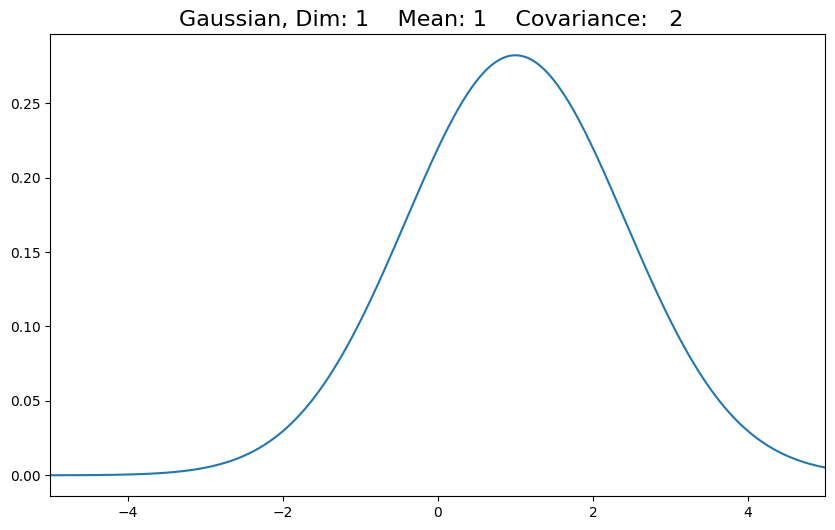

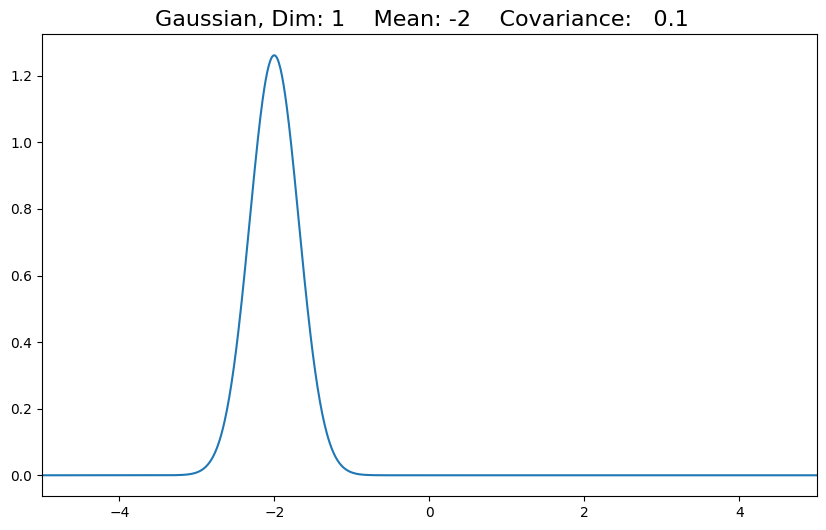

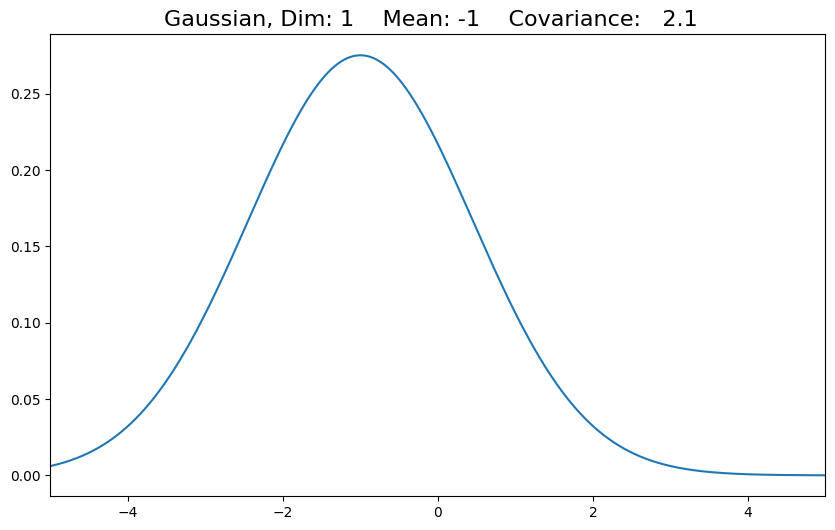

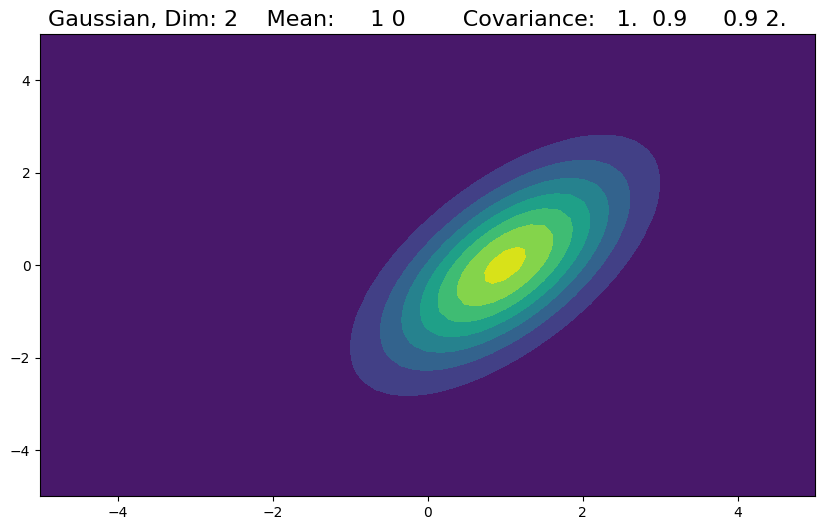

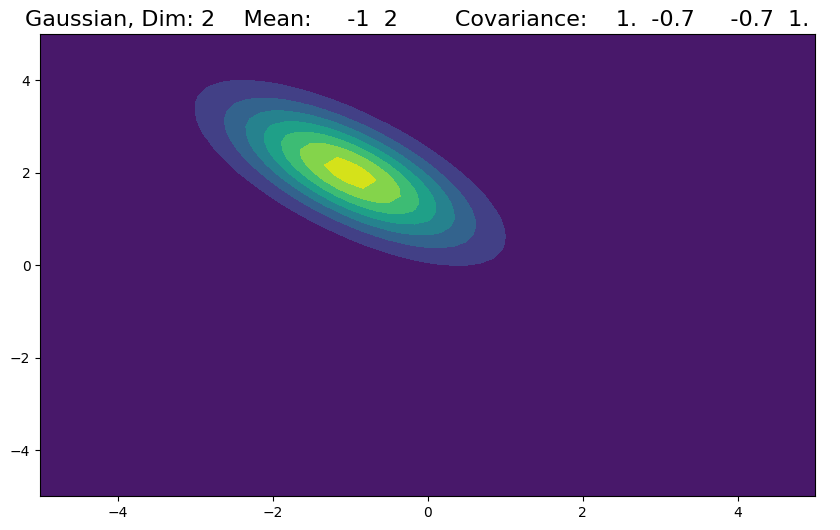

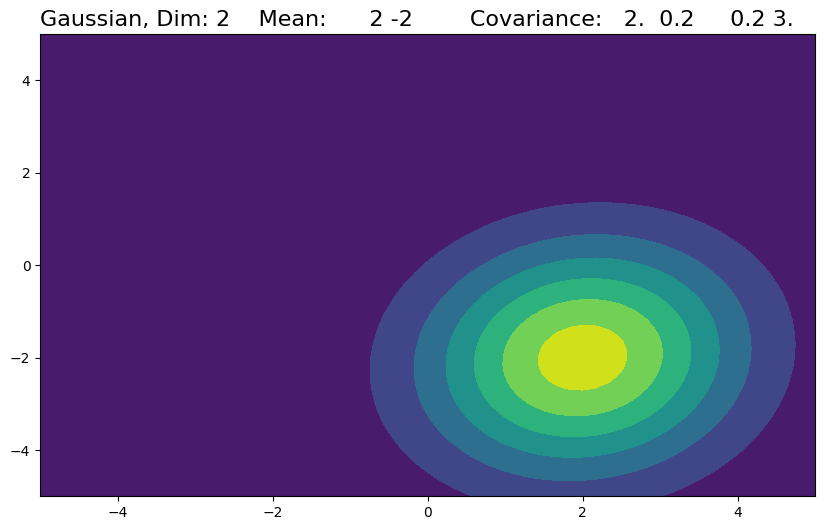

In [3]:
# EXPECTED SPACE FOR STUDENT CODE - START
gaussian_A = GaussianDistribution(mean=np.array([1]), cov=np.array([2]))
gaussian_B = GaussianDistribution(mean=np.array([-2]), cov=np.array([0.1]))
gaussian_A_B = gaussian_A.__add__(gaussian_B)
gaussian_C = GaussianDistribution(mean=np.array([1, 0]), cov=np.array([[1, 0.9], [0.9, 2]]))
gaussian_D = GaussianDistribution(mean=np.array([-1, 2]), cov=np.array([[1, -0.7], [-0.7, 1]]))
gaussian_C_D = gaussian_C.__sub__(gaussian_D)

plot_gaussian(gaussian_A)
plot_gaussian(gaussian_B)
plot_gaussian(gaussian_A_B)
plot_gaussian(gaussian_C)
plot_gaussian(gaussian_D)
plot_gaussian(gaussian_C_D)
# EXPECTED SPACE FOR STUDENT CODE - END

### Exercise 1.2
__Task__: Implement the `marginalize` function of the class GaussianDistribution. Test, for __C__, that your resulting Gaussian looks like the one in the plot. Plot the resulting distribution for __C__ when marginalizing on $y$, and on __D__ when marginalizing on $x$.

__Question__: What does one effectively do when marginalizing a variable of a distribution?

__Answer__: When we marginalize, we provide info about the probability of different values of a single variable, without considering considering the values of other varaibles. (i.e probaiblity distribution of a subset of variables by integrating (or summing in discrete case) over the other variables). Aka. we can focus on a specific subset of variables, and ignore the details of the variables that we margingalized out => thus we simplify gaussian dsitribution to focus on a specific subset


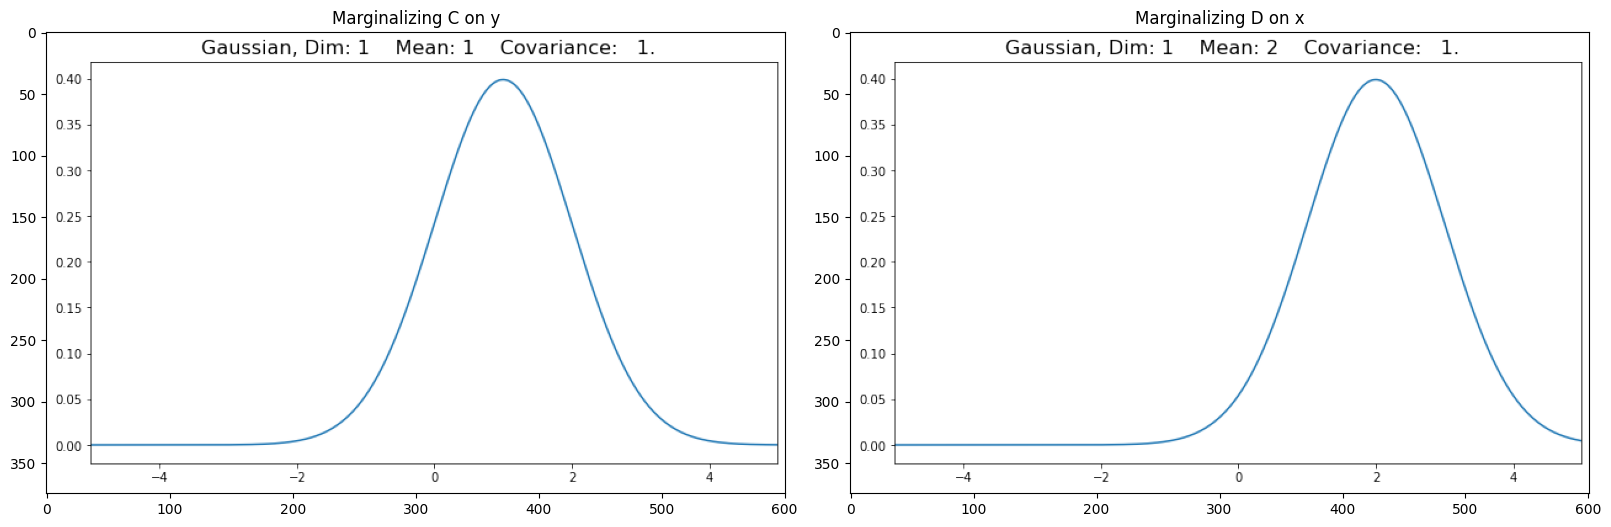

In [4]:
show_marginals()

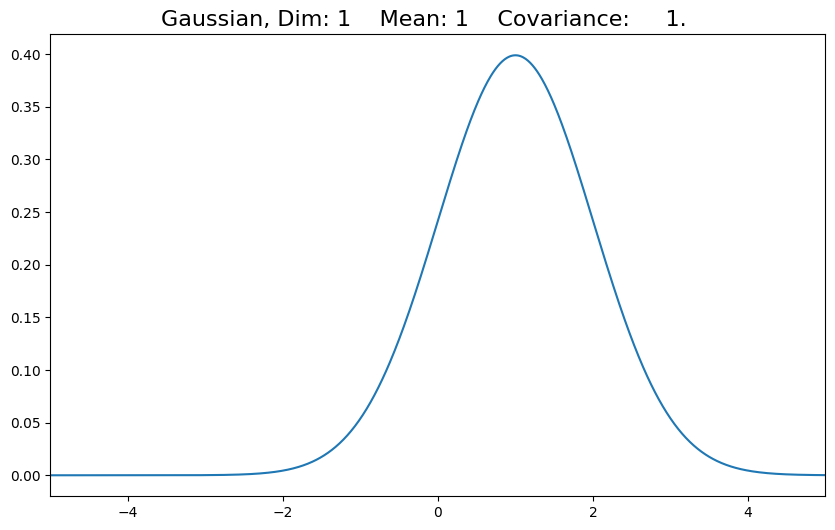

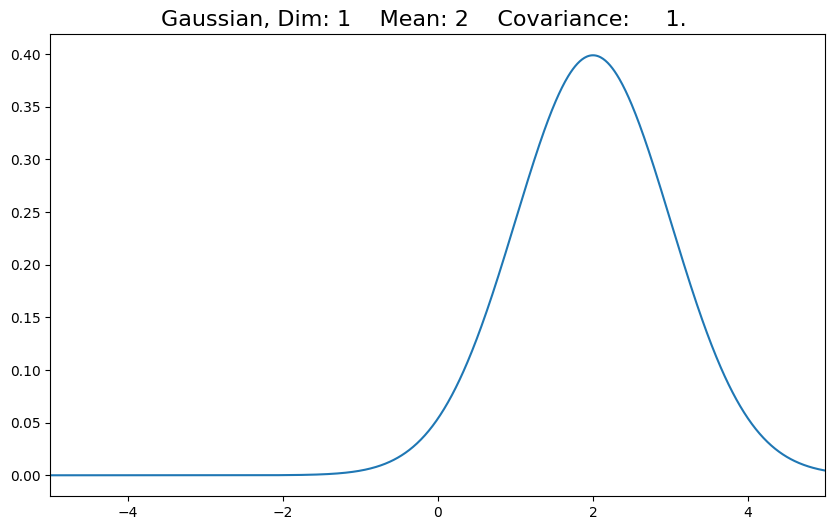

In [5]:
# Some code to test if you've marginalized distribution C correctly

#Marganalized on y (dim 1)
marg_C = gaussian_C.marginalize(dim=1)

plot_gaussian(marg_C)

#Marganalized on x (dim 0)
marg_D = gaussian_D.marginalize(dim=0)
plot_gaussian(marg_D)

### Exercise 1.3
__Task__: Implement the `get_conditional` function of the class GaussianDistribution, as specified in Lecture 2 on Gaussians. Test, for the Gaussians __C__ and __D__ from 1.1, that your resulting conditional looks like the ones in the plots, when conditioning on $x=2$ and $y=4$, respectively. 

__Hint 1__: Use the numpy arrays to retrieve the right dimensions when performing the computation (`cond_dims` are the dimensions we condition on - $y$ in the lecture notes, `non_cond_dims` are the non-conditioned dimensions - $x$ in the lectures). Example:

$\Sigma_{yx} = $ `self.cov[cond_dims, non_cond_dims][:, np.newaxis]`

__Hint 2__: Use either np.matmul, np.dot or the @ operator to perform matrix matrix multiplications.

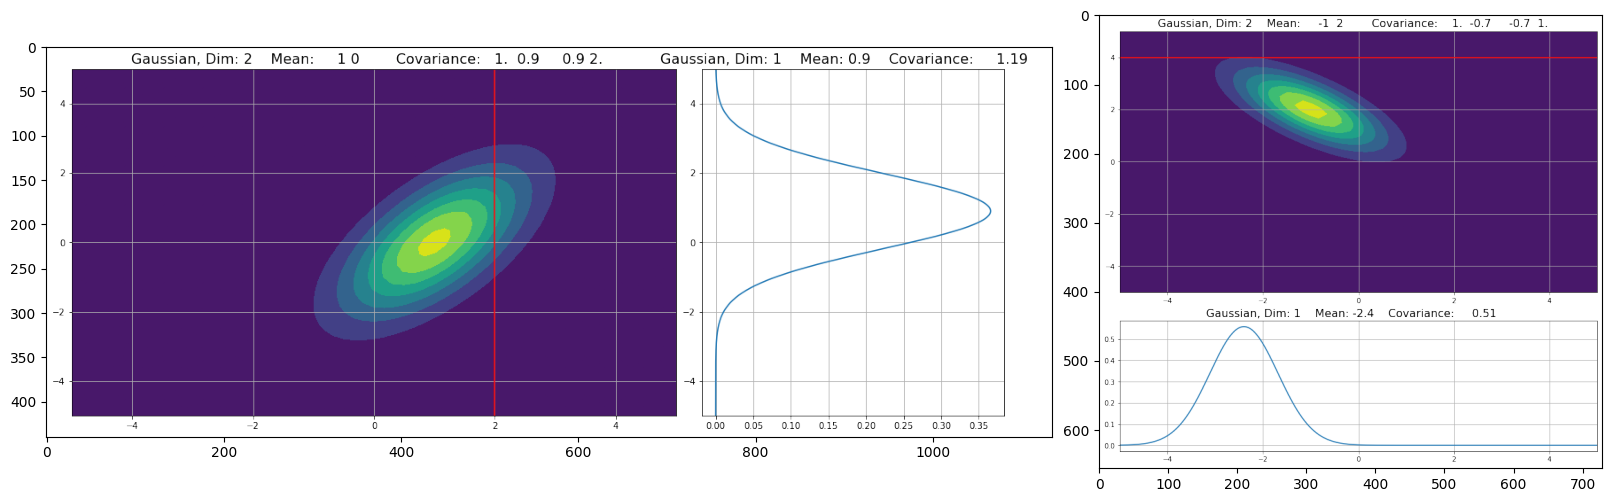

In [6]:
show_images()

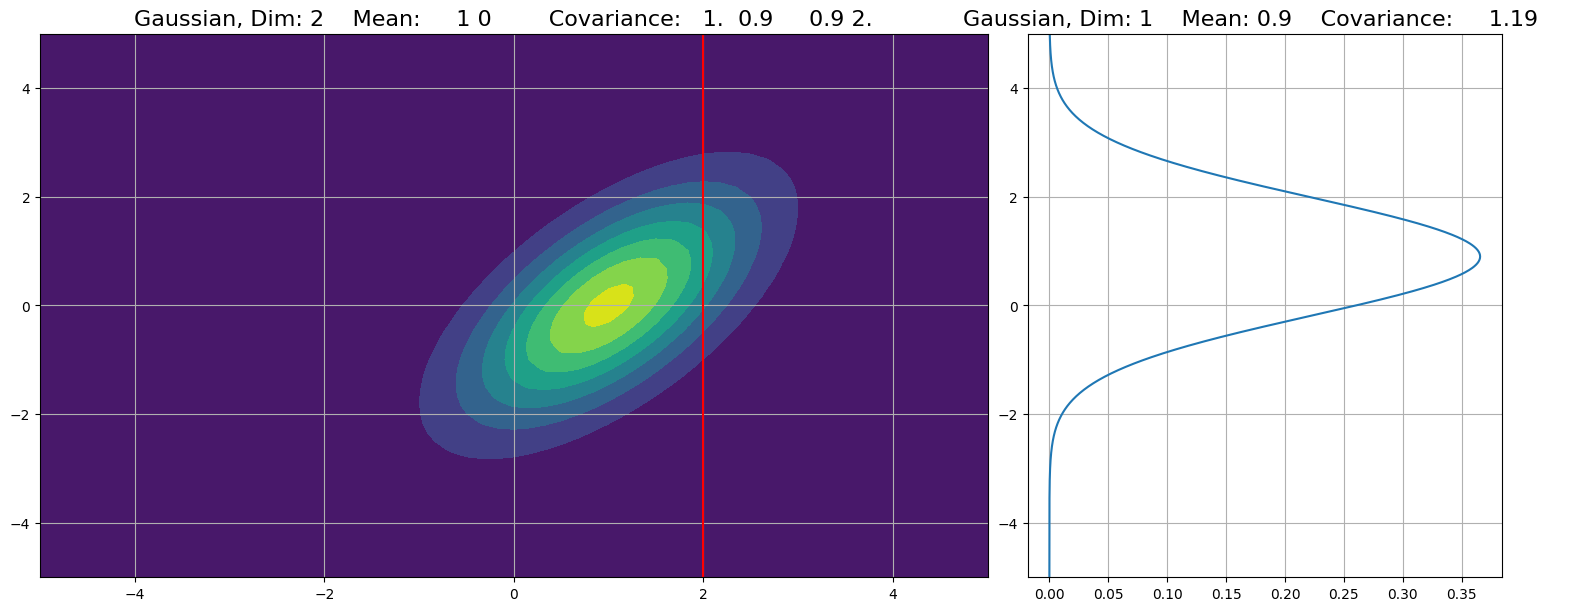

In [7]:
# Test that this produces the same plot (including the colors, which indicates the computed pdf)
gaussian_C = GaussianDistribution(mean=np.array([1, 0]), cov=np.array([[1, 0.9], [0.9, 2]]))

# Use these lines to compute the conditionals
conditional_C = gaussian_C.get_conditional(dim=0, value=2)

# Use these lines to generate the plots - plots both the initial distribution and the conditional along the right axis
plot_gaussian(gaussian_C, conditional_dist=conditional_C, condition_axis=0, condition_value=2)

# Exercise 2: Conjugate Priors

Here, we will consider the example of flipping a coin. The coin may be biased, and has a probability $\mu$ of heads. The probability of m number of heads in $N$ flips of a coin is a typical case of a *Binomial* distribution, with parameters $\mu, N$.

We would like to infer the probability $\mu$ of getting heads. We know the following in advance:
- A normal coin should have $\mu=0.5$
- The coin is weird in some way, so we cannot be sure that $\mu=0.5$ 

To model this problem using Bayesian Inference, we want two things:
- A prior probability distribution over $\mu$ (our belief of $\mu$ before seeing it)
- A likelihood function - a probability distribution over our number of observed heads (which are *$Bin(m|N, \mu$)*)

In this case, the typical choice of prior probability distribution would be a *Beta* prior (with parameters $\alpha$, $\beta$), like the one below:

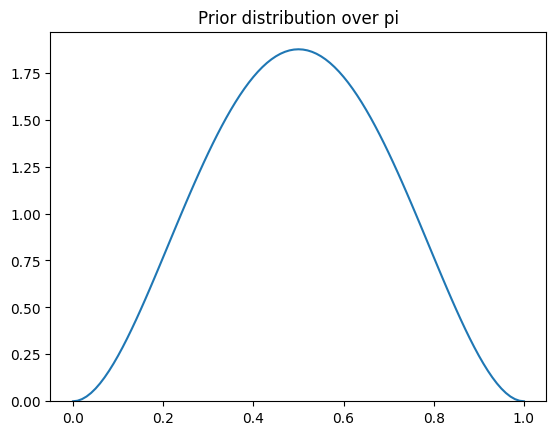

In [8]:
prior_alpha, prior_beta = 3, 3
pi_heads_prior = beta_dist(prior_alpha, prior_beta)

x = np.linspace(0, 1, 101)
y = pi_heads_prior.pdf(x)
fig2, ax2 = plt.subplots()
ax2.plot(x, y)
ax2.set_ylim(0)
ax2.set_title('Prior distribution over pi')
plt.show()

**Note**
A draw from the Beta distribution is always a number between 0 and 1, and represents our belief of the probability that we will get heads. In the example above, it says that you still think that the coin has $\mu=0.5$ of heads (as that's where the probability mass is the largest).


## Exercise 2.1

**Question**:
Toy around with the parameters of the beta distribution above. Approximately which parameters would indicate that

a. You you think that $\mu = 0.8$? (name one combination of alpha and beta)

b. You you think that $\mu = 0.2$? (name one combination of alpha and beta)

c. You are almost certain that $\mu = 0.5$?

d. You genuinely have no idea?

**Answer**:

a. prior_alpha, prior_beta = 5, 2

b. prior_alpha, prior_beta = 2, 5

c. when priopr_alpa = prior_beta where both > 1

d. When prior_alpha and prior_beta = 1, 1 

## Exercise 2.2

For the choices of distributions above (*Beta* prior, *Binomial* likelihood), the *Beta* distributions is a **conjugate prior**. This means that the posterior distribution will be of the same form as the prior. As such, when we observe our coinflips, we will update the *Beta* distribution we started with to reflect what we have learned from our observations.

**Task**: For the two coin flip datasets, compute the posterior over $\mu$ using the prior in 2.1 and the updating described in Lecture 2 on Beta-Binomial conjugacy. This method of updating the posterior distribution in closed form is unique for conjugate priors. 

In [23]:
# read the data and change the coin index
coin_index = 2
coin_flips = pd.read_csv(f'data/coin_{coin_index}.csv')
coin_flips_np = coin_flips.to_numpy()
coin_flips.head(10)

,head
0,0
1,0
2,1
3,0
4,0
5,0
6,0
7,0
8,0
9,0


**Note:** The following widget might be somewhat unresponsive. Try the text input if it does not work properly. The text input only accepts integers. If the widget does not work, continue on the next code cell instead.

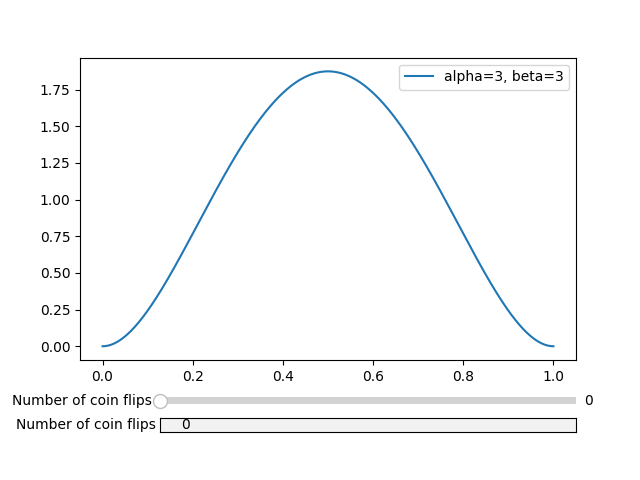

In [24]:
import time
from matplotlib.widgets import Slider, TextBox
%matplotlib widget

fig_22, ax_22 = plt.subplots()
ax_slider = fig_22.add_axes([0.25, 0.15, 0.65, 0.03])
ax_textbox = fig_22.add_axes([0.25, 0.1, 0.65, 0.03])
fig_22.subplots_adjust(bottom=0.25)

prior_alpha, prior_beta = 3, 3
x = np.linspace(0, 1, 1001)

# plot prior before starting
y = beta_dist(prior_alpha, prior_beta).pdf(x)
line, = ax_22.plot(x, y, label=f"alpha={prior_alpha}, beta={prior_beta}")
legend = ax_22.legend()

slider = Slider( ax_slider, "Number of coin flips", 0, len(coin_flips_np), valinit=0, valstep=np.arange(len(coin_flips_np)+1))
text_box = TextBox(ax_textbox, 'Number of coin flips', initial="0")

def update(val):
    if type(val) == str:
        n_iterations = int(val.strip())
    else:
        n_iterations = slider.val
    n_iterations = min(len(coin_flips_np), n_iterations)
    posterior_alpha, posterior_beta = 3, 3 # prior

    # EXPECTED SPACE FOR STUDENT CODE - START

    for i in range(n_iterations):
        # Assuming coin_flips_np is an array of 0s and 1s (tails and heads)
        observed_data = coin_flips_np[:i + 1]
        num_heads = np.sum(observed_data)
        num_tails = len(observed_data) - num_heads
        # Update posterior parameters
        posterior_alpha += num_heads
        posterior_beta += num_tails

    posterior = beta_dist(posterior_alpha, posterior_beta)
    
    # EXPECTED SPACE FOR STUDENT CODE - END

    y = posterior.pdf(x)
    line.set_ydata(y)
    legend.texts[0].set_text(f"alpha={posterior_alpha}, beta={posterior_beta}")
    ax_22.set_ylim([0, y.max()+1])
    fig_22.canvas.draw_idle()
    
slider.on_changed(update)
text_box.on_submit(update)
text_box.set_val("0")

plt.show()

**If the interactive widget does not work for some reason, work on this cell instead:**

NameError: name 'posterior' is not defined

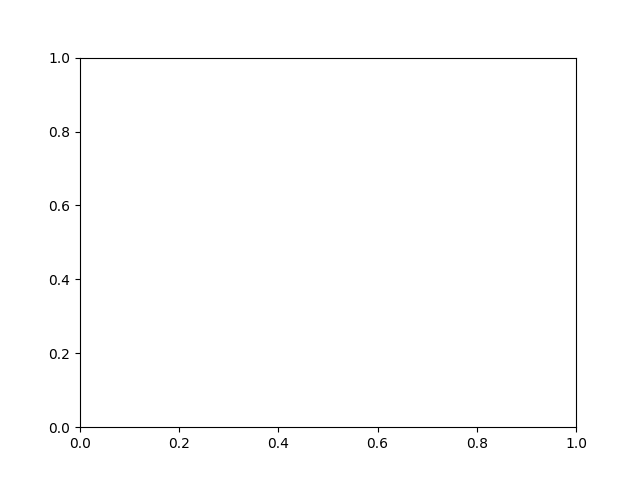

In [11]:
import matplotlib as mpl

cmap=mpl.colormaps["viridis"]

fig_27, ax_27 = plt.subplots()

x = np.linspace(0, 1, 1001)

for n_iterations in range(101):
    
    posterior_alpha, posterior_beta = 3, 3 # prior
    
    # EXPECTED SPACE FOR STUDENT CODE - START
    
    # here, you perform the posterior updating
    
    # EXPECTED SPACE FOR STUDENT CODE - END
            
    y = [posterior].pdf(x)
    if n_iterations % 10 == 0:
        ax_27.plot(x, y, label=rf"$i$={n_iterations}, $\alpha$={posterior_alpha}, $\beta$={posterior_beta}", color = cmap(n_iterations/100))
    plt.legend()
    
plt.show()

**Question**:
What posterior parameters $\alpha$, $\beta$ did you recieve for:

a. Coin index 1 using 10 flips?

b. Coin index 1 using 100 flips?

c. Coin index 2 using 10 flips?

d. Does the choice of prior matter for the the posterior distribution? When does it, and when does it not? Try for different priors and numbers of iterations.

**Answer**:

a. alpha = 43, beta = 18

b. alpha = 3336, beta = 1720

c. alpha = 11, beta = 50

d. with little data prior can be important, while for large data it is less important.

## Exercise 2.3

In the previous exercise, we learned about the conjugate prior of the Bernoulli distribution. There is a [long list](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions) of distributions with their conjugate prior. 

**Assume you want to place sport bets for the English Football League Fourth Division.** You want to bet on how many goals are scored in the next match. You want to maximize your chances and therefore use a datadriven approach. Let's first load some soccer data from English football leagues. We believe that — on average — there are around 2-3 goals per match.

It is known that the number of goals in a football match roughly follows a Poisson distribution. 

The Poisson distribution can be used to model rare events (like number of meteor strikes in a year or number of goals in a soccer match). It has probability mass function ($x$ is the number of goals, hence the Poisson distribution is a discrete distribution)
$$
    f(x;\lambda)=p_{\lambda}(x)=\frac{\lambda^xe^{-\lambda}}{x!}.
$$

The conjugate prior distribution of the Poisson distribution is the Gamma distribution with probability mass function (the Gamma distribution is continuous)
$$
    f(\lambda;\alpha,\beta)=p_{\alpha, \beta}(\lambda)=\frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{\alpha-1}e^{-\beta \lambda},
$$
where $\Gamma$ is the Gamma function which has the property $\Gamma(n)=(n-1)!$ for positive integers $n$, where $n! = \prod_{i=1}^n i$ is the *factorial* of $n$.



In [25]:
df = pd.read_csv("https://raw.githubusercontent.com/jalapic/engsoccerdata/11f9d9b7a091001e8ef8ea3a1523f4ce7fb4e897/data-raw/england.csv", on_bad_lines="warn", low_memory=False)

df = df[(df['Date'] >= '1950-01-01')] # Let's only consider somewhat recent matches

df_first_tier  = df[df["tier"] == 1]
df_second_tier = df[df["tier"] == 2]
df_third_tier  = df[df["tier"] == 3]
df_fourth_tier = df[df["tier"] == 4]
df_fourth_tier.head()

,Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result
74234,1958-08-23,1958,Barrow,Gateshead,0-3,0,3,4,4,3,-3,A
74235,1958-08-23,1958,Bradford Park Avenue,Workington,3-2,3,2,4,4,5,1,H
74236,1958-08-23,1958,Carlisle United,Aldershot,1-0,1,0,4,4,1,1,H
74237,1958-08-23,1958,Chester,Torquay United,0-2,0,2,4,4,2,-2,A
74238,1958-08-23,1958,Coventry City,Darlington,0-0,0,0,4,4,0,0,D


In [27]:
goals = df_fourth_tier["totgoal"].to_numpy()
goals

array([3, 5, 1, ..., 2, 4, 2], dtype=int64)

We know that the conjugate distribution for the Poisson distribution is the Gamma distribution. As before, we want to start with some prior but we don't know yet a lot about the Gamma distribution. Let's visualize it for some values.

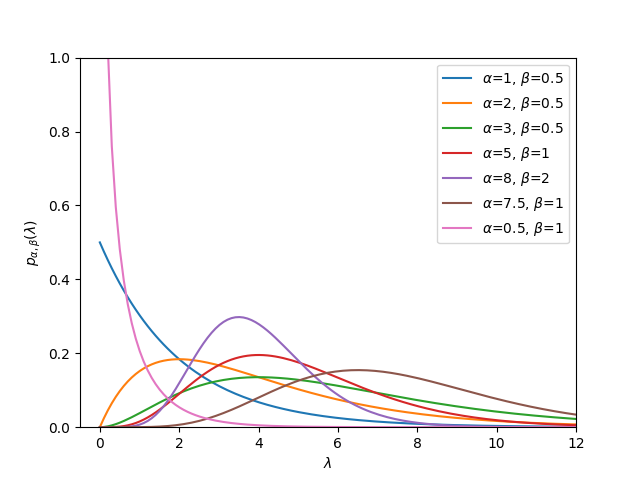

In [28]:
alphas = [1, 2, 3, 5, 8, 7.5, 0.5]
betas  = [0.5, 0.5, 0.5, 1, 2, 1, 1]

fig23, ax23 = plt.subplots()
for _alpha, _beta in zip(alphas, betas):
    ax23.plot(np.linspace(0,20,200), gamma_dist(a=_alpha, scale=1/_beta).pdf(np.linspace(0,20,200)), label=rf"$\alpha$={_alpha}, $\beta$={_beta}")
ax23.set_ylim([0, 1])
ax23.set_xlabel(r"$\lambda$")
ax23.set_ylabel(r"$p_{\alpha, \beta}(\lambda)$")
ax23.set_xlim([-0.5, 12])
ax23.legend()
plt.show()

Looking at this plot, maybe $\alpha=2$ and $\beta=0.5$ is a suitable prior — the **distribution parameter $\lambda$** of the Poisson distribution is **ideally the true mean of goals** and two goals in a match might be a reasonable guess with more goals becoming less likely.

For pedagogical reasons, let's assume you have only very limited data, i.e., **only the goals for five matches**. There certainly is a lot of uncertainty in your bet, but you still want to try your best.

To calculate the posterior of the Gamma distribution with prior distribution parameters $\alpha_0$ and $\beta_0$, we use the following [rule](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions):

$$
    \alpha'=\alpha_0+\sum_{i=1}^n x_i,\quad \beta' = \beta_0+n,
$$

where $\alpha_0$ and $\beta_0$ are the priors of the distribution parameters, $n$ is the number of data points, $x_i$ is the number of goals in the $i$-th match, and $\alpha'$ and $\beta'$ are the posteriors.

**Task:** Find the posterior values $\alpha'$ and $\beta'$.

In [29]:
goals[np.random.RandomState(seed=356).permutation(len(goals))[:5]]


array([11,  4,  2,  4,  4], dtype=int64)

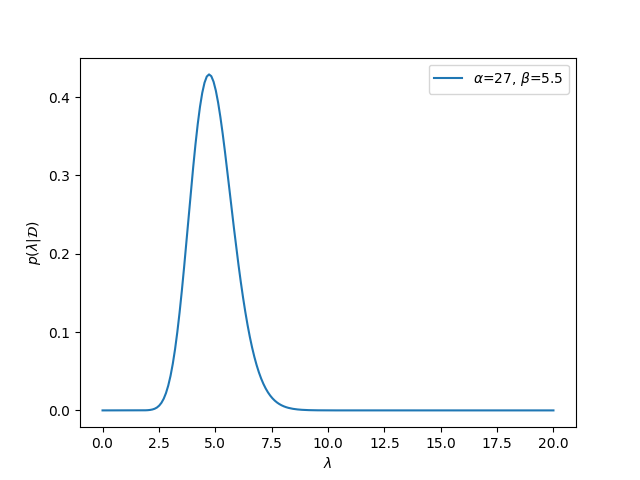

In [30]:
goals_limited = goals[np.random.RandomState(seed=356).permutation(len(goals))[:5]]

# EXPECTED SPACE FOR STUDENT CODE - START
alpha_limited = 2 + np.sum(goals_limited)
beta_limited = 0.5 + len(goals_limited)
# EXPECTED SPACE FOR STUDENT CODE - END

fig23_1, ax23_1 = plt.subplots()
ax23_1.plot(np.linspace(0,20,200), gamma_dist(a=alpha_limited, scale=1/beta_limited).pdf(np.linspace(0,20,200)), label=rf"$\alpha$={alpha_limited}, $\beta$={beta_limited}")

ax23_1.legend()
ax23_1.set_xlabel(r"$\lambda$")
ax23_1.set_ylabel(r"$p(\lambda|\mathcal{D})$")
plt.show()

**Question:** If you computed `alpha_limited` and `beta_limited` in the previous code cell without using any loops, how could you update $\alpha$ and $\beta$ iteratively, for example if you get a stream of data? Otherwise, how could you set $\alpha'$ and $\beta'$ without using any loops? 

**Answer:** Do alpha_limited += np.sum(new_data), and beta_limited+= len(new_data)

Now that you found a suitable prior, you might wonder if you rather want to place your bet using only the very limited data from five goals or if you also want to incorporate your prior belief that - on average - there are less than five goals in a match. 

In particular, you have two options:

- You approximate the goal distribution using the empirical mean as the distribution parameter (**MLE**)
- You use the point that maximizes the probability density function of your posterior distribution as the distribution parameter (**MAP**)

Points that maximize the probability density function or the probability mass function are called "modes". While in general, there might be more than one mode, for the Gamma-distribution there is only one and it can easily be found as

$$
    \hat{\lambda} = \frac{\alpha'-1}{\beta'}.
$$

**Task:** Find the mode of the posterior distribution and the empirical mean of the data.

lambda hat: 4.73


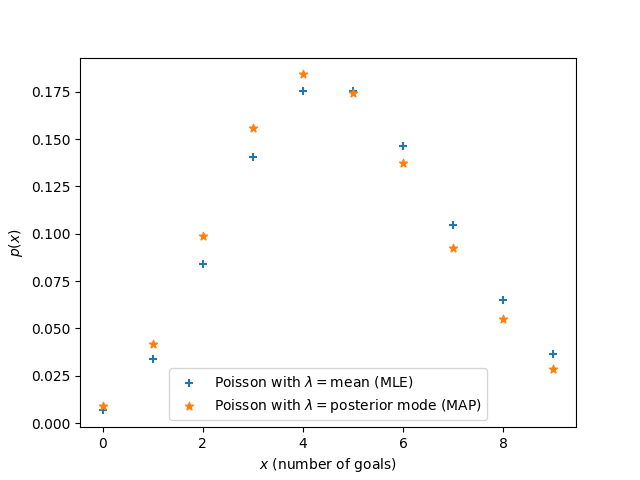

In [34]:
# EXPECTED SPACE FOR STUDENT CODE - START

def mode(alpha, beta):
     return (alpha - 1) / beta

mean_limited = np.mean(goals_limited)

# EXPECTED SPACE FOR STUDENT CODE - END

print(f"lambda hat: {mode(alpha_limited, beta_limited):.3}")

fig23_6, ax23_6 = plt.subplots()
ax23_6.scatter(np.arange(10), poisson_dist(mean_limited).pmf(np.arange(10)), marker="+", label = r"Poisson with $\lambda=$mean (MLE)")
ax23_6.scatter(np.arange(10), poisson_dist(mode(alpha_limited, beta_limited)).pmf(np.arange(10)), marker="*", label = r"Poisson with $\lambda=$posterior mode (MAP)")
ax23_6.set_xlabel(r"$x$ (number of goals)")
ax23_6.set_ylabel(r"$p(x)$")
ax23_6.legend()
plt.show()

<div class="alert alert-block alert-success">
We see that the MLE model predicts a higher probability for higher numbers of goals. The reason is that for our small subset of data, the mean is quite high and the MLE estimate is not influenced by prior belief. The MAP estimate is biased towards the prior belief of two goals per match.
</div>

Finally, for your bet, you probably want to predict the number of goals where the Poisson distribution has maximum probability mass function (again, the mode). The mode of the Poisson distribution can easily be found by

$$
    \hat{x} = \lfloor \lambda \rfloor
$$

where $\lfloor x \rfloor$ is the largest integer smaller than $x$ (or $x$, if $x$ is an integer itself, i.e., $\lfloor x \rfloor = x$ if $x\in \mathbb{N}$). This operation is called "floor function". It is implemented in Python by `math.floor`.

**Task:** Find the number of goals with the highest probability mass for the MLE and the MAP model:

In [36]:
# EXPECTED SPACE FOR STUDENT CODE - START

dst_map = poisson_dist(mode(alpha_limited, beta_limited)).pmf(np.arange(10))
dst_mle = poisson_dist(mean_limited).pmf(np.arange(10))

max_prob_mle = math.floor(np.argmax(dst_mle))
max_prob_map = math.floor(np.argmax(dst_map)) 


# EXPECTED SPACE FOR STUDENT CODE - END

print(f"Optimal number of goals (MLE): {max_goals_mle}\nOptimal number of goals (MAP): {max_goals_map}")

Optimal number of goals (MLE): 5
Optimal number of goals (MAP): 4


Ideally, you find that the two approaches give a different prediction. 

**Question:** When should you use MAP and when MLE? When are the two approaches equivalent?

**Answer:**

### Exercise 2.3.1 (Optional): Fully-Bayesian Treatment

Okay, we now have a suitable posterior distribution $p(\lambda | \mathcal{D})$ - the probability of a certain $\lambda$, given our data $\mathcal{D}$. Now, in the MAP approach, we have considered prior knowledge but only up to a certain point. In particular, we used a point estimate $\hat{\lambda}$ that maximized the posterior distribution. 

But our posterior distribution allows to predict a probability for *any* $\lambda$. Can't we marginalize over all $\lambda$ to get an even better prediction, using our posterior to the full extent?

For this, we need the *posterior predictive distribution*

$$
    p(x|\mathcal{D}) = \int_{\lambda} \underbrace{p(x|\lambda)}_{\rm Poisson}\underbrace{p(\lambda|\mathcal{D})}_{\rm Gamma}dk.
$$

The posterior predictive distribution tells us how likely a datapoint is, given the data $\mathcal{D}$ we observed by considering the likelihood of $x$ given $\lambda$ (here, Poisson distribution) and the likelihood of $\lambda$ by our posterior distribution.

Luckily, we do not have to derive the probability above ourselves but there is a closed-form solution for this: the [*Negative Binomial*](https://en.wikipedia.org/wiki/Negative_binomial_distribution) distribution

$$
    \text{NB}\left (x|\alpha', \frac{1}{1+\beta'} \right ).
$$

Let us plot the probability mass function for this probability distribution with the posteriors we derived above:

In [ ]:
fig23_2, ax23_2 = plt.subplots()
ax23_2.scatter(np.arange(10), nbinom_dist(n=alpha_limited, p=1/(1+(1/beta_limited))).pmf(np.arange(10)))
ax23_2.set_xlabel(r"$x$ (number of goals)")
ax23_2.set_ylabel(r"$p(x|\mathcal{D})$")
plt.show()

This looks very similar to a Poisson distribution we had earlier. Let's compare the different approaches:

In [ ]:
fig23_3, ax23_3 = plt.subplots()
ax23_3.scatter(np.arange(10), nbinom_dist(n=alpha_limited, p=1/(1+(1/beta_limited))).pmf(np.arange(10)), marker="x", label = "Negative Binomial (Fully-Bayesian)")
ax23_3.scatter(np.arange(10), poisson_dist(mean_limited).pmf(np.arange(10)), marker="+", label = r"Poisson with $\lambda=$mean (MLE)")
ax23_3.scatter(np.arange(10), poisson_dist(mode(alpha_limited, beta_limited)).pmf(np.arange(10)), marker="*", label = r"Poisson with $\lambda=$mode of posterior (MAP)")
ax23_3.set_xlabel(r"$x$ (number of goals)")
ax23_3.set_ylabel(r"$p(x|\mathcal{D})$")
ax23_3.legend()
plt.show()

<div class="alert alert-block alert-success">
The fully-Bayesian model considers the posterior distribution over $\lambda$, which looks like a Gaussian around the mode $\lambda'$ but slightly right-skewed. Hence, the fully-Bayesian model predicts slightly higher probabilities than the MAP model for $\lambda$ that are more distant to $\lambda'$ and lower probabilities for $\lambda$ that are close to $\lambda'$ (as the probabilities need to sum to 1). Moreover, due to the right-skewedness, the difference is more distinct for high numbers of goals than for low numbers.
</div>

Let's find the point of maximum probability in the fully-Bayesian case. The mode for the Negative Binomial distribution can be found by

$$
    \hat{x} = \begin{cases}\left \lfloor \frac{\alpha'-1}{\beta'} \right \rfloor & \text{if } \alpha'>1 \\ 0 & \text{otherwise}\end{cases}
$$

Assume that $\alpha'>1$.

**Task:** Find the number of goals with maximum probability mass for the fully-Bayesian approach (using math, not the figure).

In [ ]:
# EXPECTED SPACE FOR STUDENT CODE - START

# max_goals_fully_bayesian = ...

# EXPECTED SPACE FOR STUDENT CODE - END

print(f"Optimal number of goals (MLE): {max_goals_mle}\nOptimal number of goals (MAP): {max_goals_map}\nOptimal number of goals (Fully Bayesian):{max_goals_fully_bayesian}")

**Question:** What do you think which model you should use?

**Answer:**

But what happens if we use all the data?

**Task:** Find the posterior values $\alpha'$ and $\beta'$ when using the entire dataset.

In [ ]:
# EXPECTED SPACE FOR STUDENT CODE - START

# alpha_full = ...
# beta_full = ...

# EXPECTED SPACE FOR STUDENT CODE - END

fig23_4, ax23_4 = plt.subplots()
ax23_4.plot(np.linspace(2,3,1000), gamma_dist(a=alpha_full, scale=1/beta_full).pdf(np.linspace(2,3,1000)), label=rf"$\alpha$={alpha_full}, $\beta$={beta_full}")
ax23_4.set_xlabel(r"$\lambda$")
ax23_4.set_ylabel(r"$p(\lambda|\mathcal{D})$")
ax23_4.legend()
plt.show()

Now, the conjugate posterior is very peaked at one point. What could this point be? 

**Task:** Find the mysterious point.

In [ ]:
# EXPECTED SPACE FOR STUDENT CODE - START

# mysterious_point = ...

# EXPECTED SPACE FOR STUDENT CODE - END

mysterious_point

And what is the mean of the data?

**Task:** Find the mean of the `goals` data.

In [ ]:
# EXPECTED SPACE FOR STUDENT CODE - START

# mean_full = ...

# EXPECTED SPACE FOR STUDENT CODE - END
mean_full

**Question:** Why does this happen?

**Answer:**

Now, there should be no difference between the three approaches anymore, right?

In [ ]:
fig23_5, ax23_5 = plt.subplots()
ax23_5.scatter(np.arange(10),nbinom_dist(n=alpha_full, p=1/(1+(1/beta_full))).pmf(np.arange(10)), marker="x", label = "Negative Binomial (Fully Bayesian)")
ax23_5.scatter(np.arange(10),poisson_dist(mean_full).pmf(np.arange(10)), marker="+", label = "Poisson (MLE)")
ax23_5.scatter(np.arange(10),poisson_dist((alpha_full-1)/beta_full).pmf(np.arange(10)), marker="*", label = r"Poisson with $\lambda=$mode of posterior (MAP)")
ax23_5.set_xlabel(r"$x$ (number of goals)")
ax23_5.set_ylabel(r"$p(x|\mathcal{D})$")
ax23_5.legend()
plt.show()

Yes, the two plots overlap - which is what we expect. The posterior is very peaky and the empirical mean is close to the true mean. Note that we most likely see two goals in a match whereas we predicted 4 or 5 before.

# Exercise 3 - MLE, Overfitting and Cross-validation
Here, we are going to look at a synthetic regression problem, and how under- and overfitting can occur through better or worse model parameterizations. We will also look at the most common mean of evaluating model performance, namely cross-validation. We'll consider learning the function below through polynomial regression on a number of given data points:

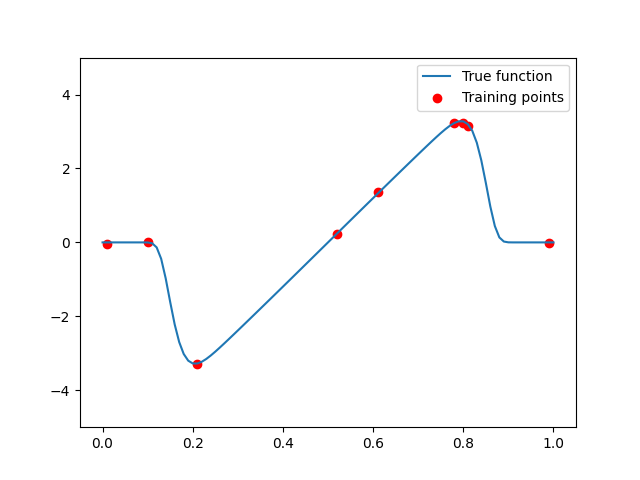

In [37]:
def true_function(X):
    return 12 * np.exp(-1e6 * np.power(1.2 * (X - 0.5), 16)) * np.sin((X - 0.5))

def noisy_function(X):
    return true_function(X) + np.random.randn(X.size) * 0.04

eval_points = np.array([0.01, 0.1, 0.21, 0.52, 0.61, 0.78, 0.80, 0.81, 0.99])
X_plot = np.linspace(0, 1, 101)

fig3, ax3 = plt.subplots()
ax3.plot(X_plot, true_function(X_plot), label='True function')
ax3.scatter(eval_points, noisy_function(eval_points), c='r', label='Training points')
ax3.legend()
ax3.set_ylim(-5, 5)
plt.show()

## Exercise 3.1
Look at the class `PolynomialRegression` (a type of Generalized Linear Model) and pay attention to its attributes and _predict_ method. This class is intended to fit a polynomial of a given degree to the data points, by calling some method to fit the data points.

__Task__: Implement the closed-form Maximum Likelihood parameter estimation in the `fit_MLE` method. The closed-form expression for the optimal parameters can be found in Lecture 4, on the section on Maximum Likelihood. Ensure it works by fitting a polynomial of degree 10 to the data points - it should fit most data points reasonably well.

__Hint__: Keep in mind that a polynomial of degree 2 has 3 coefficients.

In [38]:
class PolynomialRegression:

    #The closed-form solution for Maximum Likelihood Estimation (MLE) refers to an analytical expression that directly provides the optimal parameter values that maximize the likelihood function
    
    def __init__(self, degree):
        """
        A Polynomial Regression model of a given degree,

        Args:
            degree (int): The degree of the polynomial regression.
        """        
        self.degree = degree
        self.weights = None
        
    def fit_MLE(self, X, y):
        """
        Fits the weights of the model according to the Maximum Likelihood.

        Args:
            X ([type]): The explanatory variables of the data.
            y ([type]): The dependent variables of the data.
        """
        # EXPECTED SPACE FOR STUDENT CODE - START

        # here, you fit the weights closed-form according to MLE

        #feature matrix is created with polynomial features up to the specified degree.
        #  The matrix is initialized with ones to account for the bias term.
        feature_matrix = np.ones((len(X), self.degree+1))

        #A nested loop iterates over the data points and polynomial degrees to fill in the feature matrix.
        for i in range(len(X)):
            for j in range(self.degree+1):
                feature_matrix[i,j] = X[i] ** j
        
        #Calc optimal weights using closed-form solution
        self.weights = inv(feature_matrix.T @ feature_matrix) @ feature_matrix.T @ y

        # EXPECTED SPACE FOR STUDENT CODE - END
    
    
    def predict(self, X):
        """
        Predicts the output value(s) of a fitted model on the data point(s) X,

        Args:
            X ([type]): The explanatory variables of the data point(s) that is to 
            be predicted..

        Raises:
            ValueError: If no model is fitted (self.weights are None), no prediction
            can be made and an error is raised.

        Returns:
            np.ndarray: The predicted output value of the data point(s) X.
        """        

        if self.weights is None:
            raise ValueError('Need to fit the model before predicting!')

        theta = np.power(X[:, np.newaxis], np.arange(self.degree+1))
        preds = theta.dot(self.weights)
        return preds
            
    def print_weights(self):
        """
        Prints the weights of the model in a structured format.
        """        
        for i in range(self.degree):
            print('Coeff. theta^{}:   {:.2f}'.format(i, self.weights[i]))

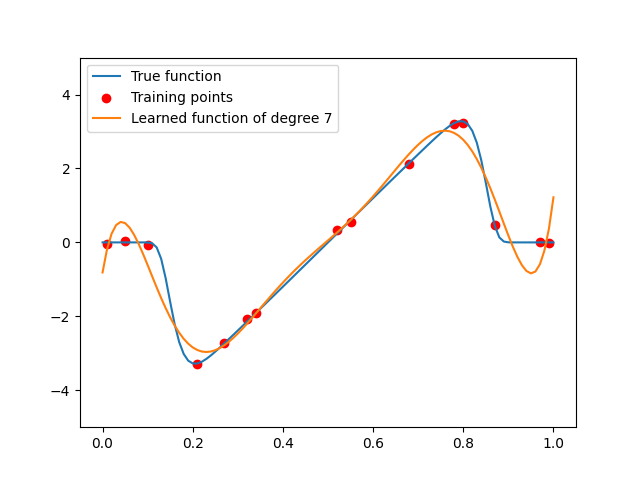

In [70]:
polynomial_degree = 7

pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig3_1, ax3_1 = plt.subplots()
ax3_1.plot(X_plot, true_function(X_plot), label='True function')

ax3_1.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_1.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_1.set_ylim(-5, 5)
ax3_1.legend()
plt.show()

## Exercise 3.2
We will now discover what happens if we under- and overfit parameters, as well as how additional data helps counteract overfitting. 

__Task__: Toy around with the fit of the generalized linear model below to find degrees where it under- and overfits. Try polynomials of different orders by changing the _polynomial_degree_ parameter. When you overfit, try change the _added_samples_ parameter.


__Questions__:

1. Judging by eye, which degree seems to consistently give the best fit?
2. How can one tell, only by looking at the parameter values of the model, if overfitting has occured?

__Answer__:

1. 7 or 8
2. The absolute values of the coefficients in the end of the function is very crooked

In [68]:
# Test out these parameters to answer the questions!
polynomial_degree = 7
added_samples = 30

pr = PolynomialRegression(polynomial_degree)
X_added = np.random.uniform(size=added_samples)
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
y_added = noisy_function(X_added)

all_X = np.append(X_eval, X_added, axis=0)
all_y = np.append(y_eval, y_added, axis=0)

pr.fit_MLE(all_X, all_y)
pr.print_weights()

Coeff. theta^0:   0.71
Coeff. theta^1:   -122.78
Coeff. theta^2:   4285.83
Coeff. theta^3:   -57851.39
Coeff. theta^4:   374904.77
Coeff. theta^5:   -1311719.25
Coeff. theta^6:   2420262.94
Coeff. theta^7:   -1372971.15
Coeff. theta^8:   -3529384.49
Coeff. theta^9:   8775033.91
Coeff. theta^10:   -8783238.04
Coeff. theta^11:   4364303.78


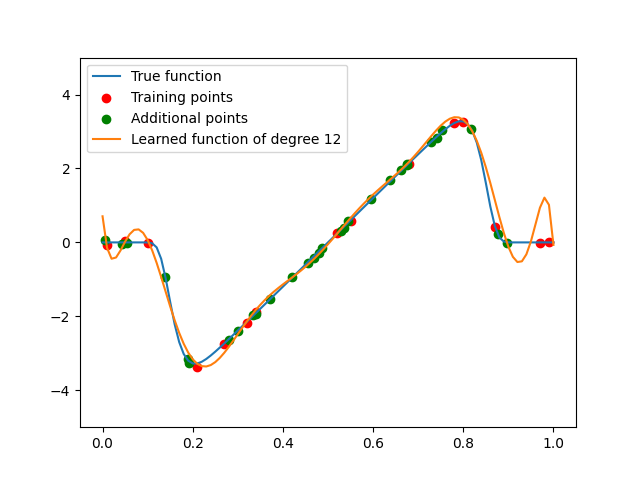

In [69]:
X_plot = np.linspace(0, 1, 101)
fig3_2, ax3_2 = plt.subplots()

ax3_2.plot(X_plot, true_function(X_plot), label='True function')

ax3_2.scatter(X_eval, y_eval, c='r', label='Training points')
if added_samples > 0:
    ax3_2.scatter(X_added, y_added, c='g', label='Additional points')
ax3_2.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_2.set_ylim(-5, 5)
ax3_2.legend()
plt.show()

## Exercise 3.3
To evaluate the models produced, one commonly uses cross-validation. 

__Task__: Implement K-fold cross validation and find your best model with RMSE as your metric. Plot the best model. Use only the initial data, without additional samples. Implement yourself or use an existing tool, e.g.  <a href="http://scikit-learn.org/stable/modules/cross_validation.html" title="Scikit-Learn Cross Validation">Scikit-Learn</a>.

__Tip__: Ensure nearby points don't go in the same batch, so that every model has data from the entire space.

__Question__:
What performance (RMSE, average on the test sets) did your top-performing model yield for K = 5?

__Answer__:

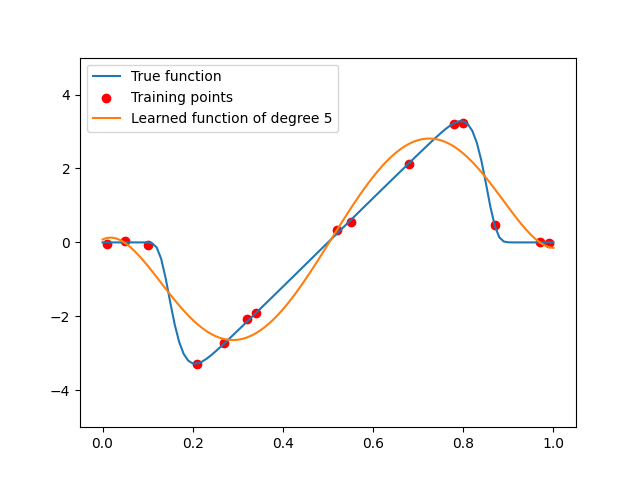

In [73]:
# EXPECTED SPACE FOR STUDENT CODE - START
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

kFold = KFold(n_splits=5, shuffle=True)
rmse_avg = []

for i in range(1, 10):
    pr = PolynomialRegression(i)
    rmse_sets = []
    
    for train, test in kFold.split(X_eval):
        X_train, X_test = X_eval[train], X_eval[test]
        y_train, y_test = y_eval[train], y_eval[test]
        
        pr.fit_MLE(X_train, y_train)
        y_predict = pr.predict(X_test)
        rmse_sets.append(mse(y_predict, y_test, squared=False))

    mean_rmse = np.mean(rmse_sets)
    rmse_avg.append(mean_rmse)

best_pol_deg = np.argmin(rmse_avg) + 1
pr = PolynomialRegression(best_pol_deg)
pr.fit_MLE(X_eval, y_eval)

# Plotting
fig3_3, ax3_3 = plt.subplots()
ax3_3.plot(X_plot, true_function(X_plot), label='True function')
ax3_3.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_3.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {best_pol_deg}')
ax3_3.set_ylim(-5, 5)
ax3_3.legend()
plt.show()



# EXPECTED SPACE FOR STUDENT CODE - END

## Exercise 3.4 (Optional)

You might have noticed that when you set the polynomial degree higher than the number of data points, the polynomial does not fit the data perfectly. However, this is what you would expect as the linear system of equations is overconstrained (test this by, e.g., using a polynomial of degree 100):

In [ ]:
polynomial_degree = 100

pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig3_3, ax3_3 = plt.subplots()
ax3_3.plot(X_plot, true_function(X_plot), label='True function')

ax3_3.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_3.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_3.set_ylim(-5, 5)
ax3_3.legend()
plt.show()

In the lecture, you learned about the closed-form MLE solution which you probably used to solve above question. However, note that our original problem is a least squares problem:

$$
   \min_{\mathbf{\beta}} || \mathbf{y} - \theta\beta  ||^{2}
$$

You might have noticed that for high polynomial degrees, the polynomial does not fit the datapoints perfectly - even though this is what you would expect. This is because using the closed-form solution is numerically unstable. In fact, we are better off using NumPy's `numpy.linalg.lstsq` which takes the coefficient matrix $\theta$ and the vector $\mathbf{y}$ as input and returns a $\beta$ that satisfies above formula. `numpy.linalg.lstsq` uses an iterative approach for solving the problem and is much more stable.

**Task:** Change the `fit_MLE` function to use `numpy.linalg.lstsq` and see how the solution gets more stable by using polynomials of high degrees. Note that `numpy.linalg.lstsq` returns a tuple from which you need the first element, also you might want to set `rcond=None` when calling `numpy.linalg.lstsq` to suppress warnings.

After changing the `fit_MLE` function, the polynomial of degree 100 should fit all points perfectly.